Cosas para modificar :
 - El pickle que contiene los parámetros de la transformación tiene que tener un tag de la parte a modificar
 

In [1]:
!pip install simpleITK

In [2]:
import sys 
sys.path.append('/content/drive/MyDrive/Balseiro/Maestría/Implementación/1-DL')
%load_ext autoreload
%autoreload 1
%aimport DataLoading 
DL = DataLoading
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import pickle
import SimpleITK as sitk

In [2]:
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    # plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    print('Metric :', registration_method.GetMetricValue())
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data

    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [21]:
# Folder Paths

f140114_5dpf = "/content/drive/MyDrive/Balseiro/Maestría/Implementación/Datos/140114_5dpf"  # 5 days post-fertilization
f140117_3dpf = "/content/drive/MyDrive/Balseiro/Maestría/Implementación/Datos/140117_3dpf"  # 3 days post-fertilization
f140115_1dpf = "/content/drive/MyDrive/Balseiro/Maestría/Implementación/Datos/140315_1dpf"  # 1 days post-fertilization

f140315_3dpf = "/content/drive/MyDrive/Balseiro/Maestría/Implementación/Datos/140315_3dpf"     # 3 days post-fertilization
f140415_5dpf_4X = "/content/drive/MyDrive/Balseiro/Maestría/Implementación/Datos/140415_5dpf_4X"  # 5 days post-fertilization
f140419_5dpf = "/content/drive/MyDrive/Balseiro/Maestría/Implementación/Datos/140519_5dpf"     # 5 days post-fertilization

f140714_5dpf = "/content/drive/MyDrive/Balseiro/Maestría/Implementación/Datos/140714_5dpf"
f140827_3dpf_4X = "/content/drive/MyDrive/Balseiro/Maestría/Implementación/Datos/140827_3dpf_4X"
f140827_5dpf_4X = '/content/drive/MyDrive/Balseiro/Maestría/Implementación/Datos/140827_5dpf_4X'

folder_paths = [f140114_5dpf, f140117_3dpf, f140115_1dpf, f140315_3dpf, f140415_5dpf_4X, f140419_5dpf, f140714_5dpf, f140827_3dpf_4X, f140827_5dpf_4X]
results_folder = '/content/drive/MyDrive/Balseiro/Maestría/Implementación/1-DL/Resultados/'

In [22]:
dfs = [DL.ZebraDataset(dataset) for dataset in folder_paths]

for df in dfs:
  
  print('\n', str(df.folderName))
  # solo cargo los parámetros
  df.loadImages(sample = 'head')
  df.loadRegTransforms()

  1%|          | 4/361 [00:00<00:10, 34.99it/s]


 140114_5dpf


  1%|          | 4/361 [00:00<00:09, 38.01it/s]


 140117_3dpf


  0%|          | 2/720 [00:00<00:39, 17.98it/s]


 140315_1dpf


  1%|          | 5/720 [00:00<00:19, 37.28it/s]


 140315_3dpf


  1%|          | 2/360 [00:00<00:23, 15.18it/s]


 140415_5dpf_4X


  1%|          | 6/720 [00:00<00:12, 55.31it/s]


 140519_5dpf


  1%|          | 5/720 [00:00<00:20, 35.01it/s]


 140714_5dpf


  0%|          | 0/360 [00:00<?, ?it/s]


 140827_3dpf_4X


  1%|          | 2/360 [00:00<00:21, 16.81it/s]


 140827_5dpf_4X


100%|██████████| 360/360 [00:20<00:00, 17.69it/s]


140117_3dpf
(0.09374391100658792, -0.27902500369871, -61.275244042680185)


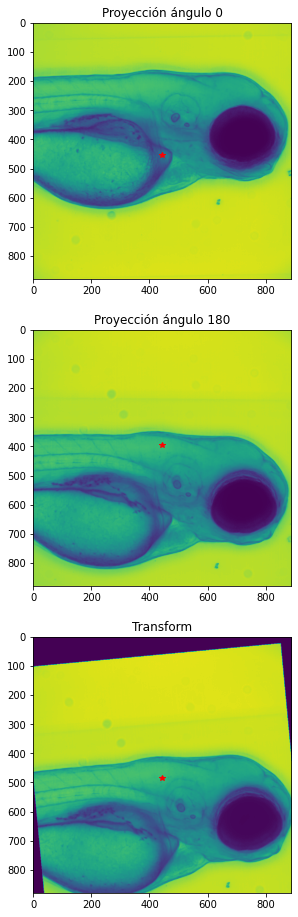

In [9]:
angle, max_angle = 0, 180
dfs_idx = 1

print(str(dfs[dfs_idx].folderName))
fixed = dfs[dfs_idx].dataset[dfs[dfs_idx].dataset.Angle == angle].iloc[0]['Image'].astype(float)
moving = np.flipud(dfs[dfs_idx].dataset[dfs[dfs_idx].dataset.Angle == angle+max_angle].iloc[0]['Image']).astype(float)

fixed_s = sitk.Cast(sitk.GetImageFromArray(fixed), sitk.sitkFloat32)
moving_s = sitk.Cast(sitk.GetImageFromArray(moving), sitk.sitkFloat32)

rglaplacianfilter = sitk.LaplacianRecursiveGaussianImageFilter()
rglaplacianfilter.SetSigma(6)
# rglaplacianfilter.SetNormalizeAcrossScale(True)

grayscale_dilate_filter = sitk.GrayscaleDilateImageFilter()
IsoData = sitk.IsoDataThresholdImageFilter()

fixed_s_f  = rglaplacianfilter.Execute(fixed_s)
fixed_s_f = grayscale_dilate_filter.Execute(fixed_s)
fixed_s_f = sitk.BinaryFillhole(IsoData.Execute(fixed_s))

moving_s_f  = rglaplacianfilter.Execute(moving_s)
moving_s_f = grayscale_dilate_filter.Execute(moving_s)
moving_s_f = sitk.BinaryFillhole(IsoData.Execute(moving_s))

# chequeo el algoritmo de registración
# Registration algorithm
R = sitk.ImageRegistrationMethod()

# Similarity metric, optimizer and interpolator
R.SetMetricAsCorrelation()
R.SetOptimizerAsGradientDescentLineSearch(learningRate=0.05,
                                          numberOfIterations=10)
R.SetInterpolator(sitk.sitkLinear)

fixed_s_f = sitk.Cast(fixed_s_f, sitk.sitkFloat32)
moving_s_f = sitk.Cast(moving_s_f, sitk.sitkFloat32)

# Initial Transform - Aligns center of mass (same modality)
initialT = sitk.CenteredTransformInitializer(fixed_s, 
                                  moving_s, 
                                  sitk.Euler2DTransform(), 
                                  sitk.CenteredTransformInitializerFilter.MOMENTS)

R.SetInitialTransform(initialT)

outTx = R.Execute(fixed_s_f, moving_s_f) # Rotation + traslation
params = outTx.GetParameters()
transform = sitk.Resample(moving_s, 
                          outTx, 
                          sitk.sitkLinear, 
                          0.0,
                          moving_s.GetPixelID())

fixed = sitk.GetArrayFromImage(fixed_s)
moving = sitk.GetArrayFromImage(moving_s)
print(outTx.GetParameters())
fig, ax = plt.subplots(3, 1, figsize = (12,16))

ax[0].imshow(fixed)
ax[0].set_title('Proyección ángulo {}'.format(angle))
ax[0].plot(*ndimage.center_of_mass(fixed)[::-1], 'r*')

ax[1].imshow(moving)
ax[1].plot(*ndimage.center_of_mass(moving)[::-1], 'r*')
ax[1].set_title('Proyección ángulo {}'.format(angle+max_angle))

ax[2].imshow(sitk.GetArrayFromImage(transform))
ax[2].plot(*ndimage.center_of_mass(np.flipud(moving))[::-1], 'r*')
ax[2].set_title('Transform'.format(angle+max_angle))

fig.show()

Preprocessing (0.23806209072212353, 26.286987428216886, 17.014539986449144)
No Preprocessing (0.13981945294720327, -2.8795424163564443, -5.647895403285645)


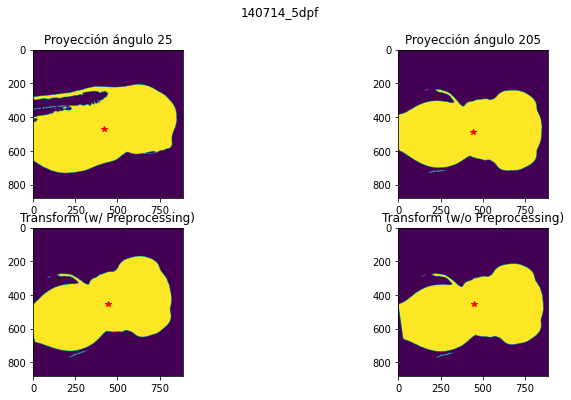

In [25]:
#Pruebas con y sin preprocesamiento para los distintos objetivos
dfs_idx = 6
angle, max_angle = 25, 180

fixed = dfs[dfs_idx].dataset[dfs[dfs_idx].dataset.Angle == angle].iloc[0]['Image'].astype(float)
moving = np.flipud(dfs[dfs_idx].dataset[dfs[dfs_idx].dataset.Angle == angle+max_angle].iloc[0]['Image']).astype(float)

fixed_s = sitk.Cast(sitk.GetImageFromArray(fixed), sitk.sitkFloat32)
moving_s = sitk.Cast(sitk.GetImageFromArray(moving), sitk.sitkFloat32)

rglaplacianfilter = sitk.LaplacianRecursiveGaussianImageFilter()
rglaplacianfilter.SetSigma(6)
rglaplacianfilter.SetNormalizeAcrossScale(True)
grayscale_dilate_filter = sitk.GrayscaleDilateImageFilter()
IsoData = sitk.IsoDataThresholdImageFilter()

fixed_s_f  = rglaplacianfilter.Execute(fixed_s)
fixed_s_f = grayscale_dilate_filter.Execute(fixed_s)
fixed_s_f = sitk.BinaryFillhole(IsoData.Execute(fixed_s))

moving_s_f  = rglaplacianfilter.Execute(moving_s)
moving_s_f = grayscale_dilate_filter.Execute(moving_s)
moving_s_f = sitk.BinaryFillhole(IsoData.Execute(moving_s))

# Casting
fixed_s_f = sitk.Cast(fixed_s_f, sitk.sitkFloat32)
moving_s_f = sitk.Cast(moving_s_f, sitk.sitkFloat32)
# Preprocessing initialization

fixed_f = sitk.GetArrayFromImage(fixed_s_f)
moving_f = sitk.GetArrayFromImage(moving_s_f)

# Registration algorithm
R = sitk.ImageRegistrationMethod()

# Similarity metric, optimizer and interpolator
R.SetMetricAsCorrelation()
R.SetOptimizerAsGradientDescentLineSearch(learningRate=0.05,
                                          numberOfIterations=10)
R.SetInterpolator(sitk.sitkLinear)

initialT = sitk.CenteredTransformInitializer(fixed_s_f, 
                                  moving_s_f, 
                                  sitk.Euler2DTransform(), 
                                  sitk.CenteredTransformInitializerFilter.MOMENTS)

R.SetInitialTransform(initialT)

outTx = R.Execute(fixed_s_f, moving_s_f) # Rotation + traslation
print('Preprocessing', outTx.GetParameters())
transform_pre = sitk.Resample(moving_s_f, 
                          outTx, 
                          sitk.sitkLinear, 
                          0.0,
                          moving_s_f.GetPixelID())

# No preprocessing initialization

initialT = sitk.CenteredTransformInitializer(fixed_s, 
                                  moving_s, 
                                  sitk.Euler2DTransform(), 
                                  sitk.CenteredTransformInitializerFilter.MOMENTS)

R.SetInitialTransform(initialT)

outTx = R.Execute(fixed_s_f, moving_s_f) # Rotation + 
print('No Preprocessing', outTx.GetParameters())
transform_nopre = sitk.Resample(moving_s_f, 
                          outTx, 
                          sitk.sitkLinear, 
                          0.0,
                          moving_s_f.GetPixelID())

fig, ax = plt.subplots(2, 2, figsize = (12,6))
fig.suptitle(str(dfs[dfs_idx].folderName))
ax[0,0].imshow(fixed_f)
ax[0,0].set_title('Proyección ángulo {}'.format(angle))
ax[0,0].plot(*ndimage.center_of_mass(fixed_f)[::-1], 'r*')

ax[0,1].imshow(moving_f)
ax[0,1].plot(*ndimage.center_of_mass(moving_f)[::-1], 'r*')
ax[0,1].set_title('Proyección ángulo {}'.format(angle+max_angle))

ax[1,0].imshow(sitk.GetArrayFromImage(transform_pre))
ax[1,0].plot(*ndimage.center_of_mass(np.flipud(moving))[::-1], 'r*')
ax[1,0].set_title('Transform (w/ Preprocessing)'.format(angle+max_angle))

ax[1,1].imshow(sitk.GetArrayFromImage(transform_nopre))
ax[1,1].plot(*ndimage.center_of_mass(np.flipud(moving))[::-1], 'r*')
ax[1,1].set_title('Transform (w/o Preprocessing)'.format(angle+max_angle))

fig.show()
fig.savefig(results_folder+'{}_registration.pdf'.format(str(dfs[dfs_idx].folderName)), bbox_inches = 'tight')

In [8]:
dfs[1].dataset.Angle.to_numpy()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [ ]:
# 1 - Ver si puedo salvar las transformaciones
# df.saveRegTransforms()
# bis para no cagarla otra vez
with open(str(df.folderPath)+'transform.pickle', 'wb') as h:
  pickle.dump(df.Tparams,  h)

In [10]:
for t in Tx:
  print(len(t))

180
180
360
360
180
360
360
180


Text(0.5, 0, 'Ty registración$\\;[pixels]$')

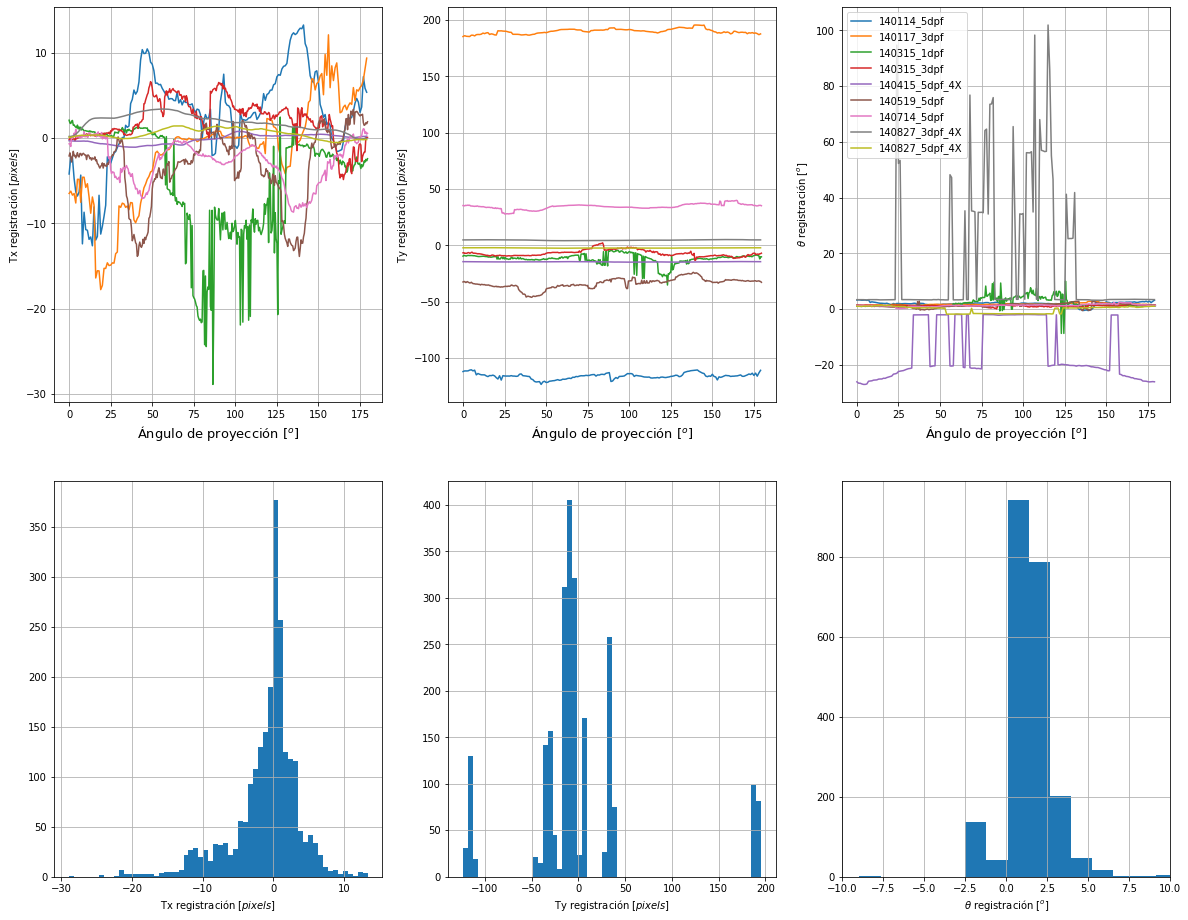

In [23]:
# Angulos de rotación
angles = [df.Tparams['theta'].to_numpy() for df in dfs]
angles[2][np.argmin(angles[2])] = angles[2][np.argmin(angles[2])-3] 
Ty = [df.Tparams['Ty'].to_numpy() for df in dfs]
Tx = [df.Tparams['Tx'].to_numpy() for df in dfs]
names = [str(df.folderName) for df in dfs]

fig, ax = plt.subplots(2,3, figsize = (20,16))

#for angle in angles:
for df, tx, name in zip(dfs, Tx, names):

  angle_proj = df.dataset.Angle.to_numpy()
  
  if angle_proj.max() > 360:
    
    angle_proj = (angle_proj/2)[:len(angle_proj)//2]
  else:
    angle_proj = (angle_proj)[:len(angle_proj)//2]
  # ax.plot(angle*180/np.pi)
  ax[0,0].plot(angle_proj, tx, label = name)

for df, ty, name in zip(dfs, Ty, names):
  # ax.plot(angle*180/np.pi)
  angle_proj = df.dataset.Angle.to_numpy()
  
  if angle_proj.max() > 360:
    angle_proj = (angle_proj/2)[:len(angle_proj)//2]
  else:
    angle_proj = (angle_proj)[:len(angle_proj)//2]

  ax[0,1].plot(angle_proj,ty, label = name)

for df, angle, name in zip(dfs, angles, names):
  
  angle_proj = df.dataset.Angle.to_numpy()
  
  if angle_proj.max() > 360:
    angle_proj = (angle_proj/2)[:len(angle_proj)//2]
  else:
    angle_proj = (angle_proj)[:len(angle_proj)//2]
  # ax.plot(angle*180/np.pi)
  ax[0,2].plot(angle_proj, angle*180/np.pi, label = name)

ax[0,2].set_ylabel(r'$\theta$ registración$\;[^o]$')
ax[0,0].set_ylabel(r'Tx registración$\;[pixels]$')
ax[0,1].set_ylabel(r'Ty registración$\;[pixels]$')

for axs in ax[0,:]:
  axs.grid(True)
  axs.set_xlabel(r'Ángulo de proyección $[^o]$', fontsize = 13)

ax[0,2].legend()
for axs in ax[1,:]:
  axs.grid(True)

ax[1,0].hist(np.hstack(Tx), bins = 60)
ax[1,1].hist(np.hstack(Ty), bins = 60)
ax[1,2].hist(np.hstack(angles)*180/np.pi, bins = 100)
ax[1,2].set_xlim((-10, 10))

ax[1,2].set_xlabel(r'$\theta$ registración$\;[^o]$')
ax[1,0].set_xlabel(r'Tx registración$\;[pixels]$')
ax[1,1].set_xlabel(r'Ty registración$\;[pixels]$')

# fig.savefig(results_folder+'{}_registration.pdf'.format('mixedPreprocessing'), bbox_inches = 'tight')

In [ ]:
np.argmin(angles[2])

249

In [ ]:
angles[2].min()

-50.10266887306848

In [ ]:
np.array([angle.max() for angle in angles])

array([ 0.05872241,  0.04923712,  0.17580635,  0.02942819,  0.03967062,
        0.05099865,  0.04216923, -0.00061093,  0.01910726])

In [ ]:
# 2 - Ver si puedo cargar las tranformaciones
df_nuevo = DL.ZebraDataset(f140114_5dpf)
df_nuevo.loadRegTransforms()

[autoreload of DataLoading failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/content/drive/MyDrive/Balseiro/Maestría/Implementación/1-DL/DataLoading.py", line 271
    pickle.dump({'reg_dataset' : self.registeredDataset,
         ^
IndentationError: expected an indented block
]


In [ ]:
# 3 - Ver si puedo registrar a partir de dichas transformaciones
df_nuevo.loadImages()
df_nuevo.loadRegTransforms()

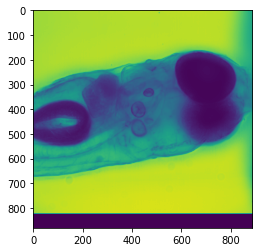

In [ ]:
angle = 30
plt.imshow(df.registeredDataset[(df.registeredDataset.Sample == 0) & (df.registeredDataset.Angle == angle)]['Image'].iloc[0])

In [ ]:
# Pickleo todo
df.pickle_file = open(str(df.folderPath)+'.pickle', 'wb')
pickle.dump({'reg_dataset' : df.registeredDataset,'reg_transform' : df.Tparams}, pickle_file)

In [ ]:
# uplodeo todo/ Para la prox
df.saveRegisteredDataset()

In [ ]:
# le saco las primeras porque son caca


In [ ]:
df_other = DL.ZebraDataset(f140114_5dpf)

In [ ]:
df_other.loadRegisteredDataset()

EOFError: ignored

In [ ]:
raw_volume = np.stack(df.registerDataset['Image'].to_numpy()) # [Angle, z, ]
raw_volume_notreg = np.stack(df.dataset[df.dataset.Sample == 0]['Image'].to_numpy())

Text(0.5, 1.0, 'Not registered Dataset')

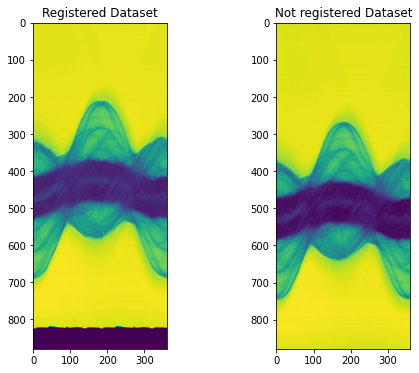

In [ ]:
from skimage.transform import radon, iradon

Text(0.5, 1.0, 'Not registered Dataset')

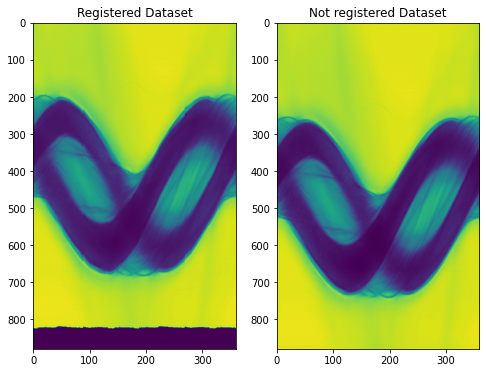

In [ ]:
z = 800
reg = raw_volume[:, :, z].T
notReg = raw_volume_notreg[:-1, :, z].T

fig, ax = plt.subplots(1,2, figsize = (8,6))

ax[0].imshow(reg, aspect = 'auto')
ax[0].set_title('Registered Dataset')

ax[1].imshow(notReg, aspect = 'auto')
ax[1].set_title('Not registered Dataset')

In [ ]:
angles = np.arange(0, 360, 1)
rec_reg = iradon(reg, angles)
rec_notReg = iradon(notReg, angles)

Text(0.5, 1.0, 'Not registered Dataset')

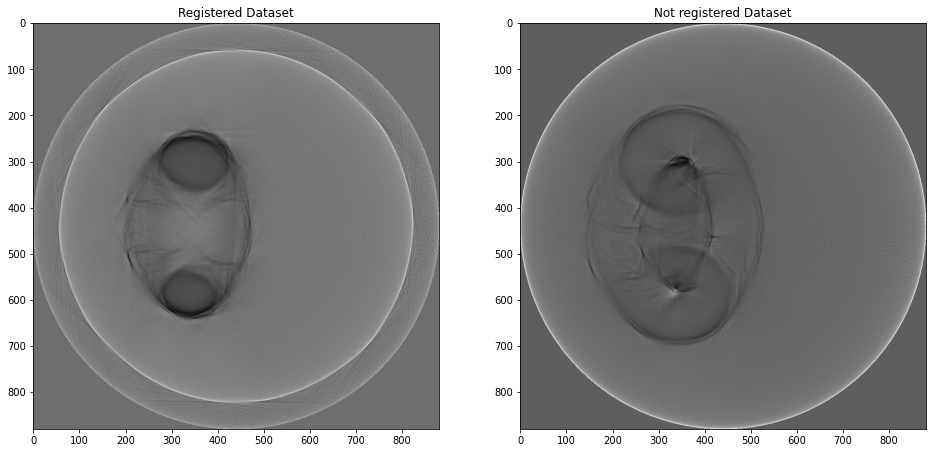

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (16,12))

ax[0].imshow(rec_reg, cmap = 'gray')
ax[0].set_title('Registered Dataset')

ax[1].imshow(rec_notReg, cmap = 'gray')
ax[1].set_title('Not registered Dataset')

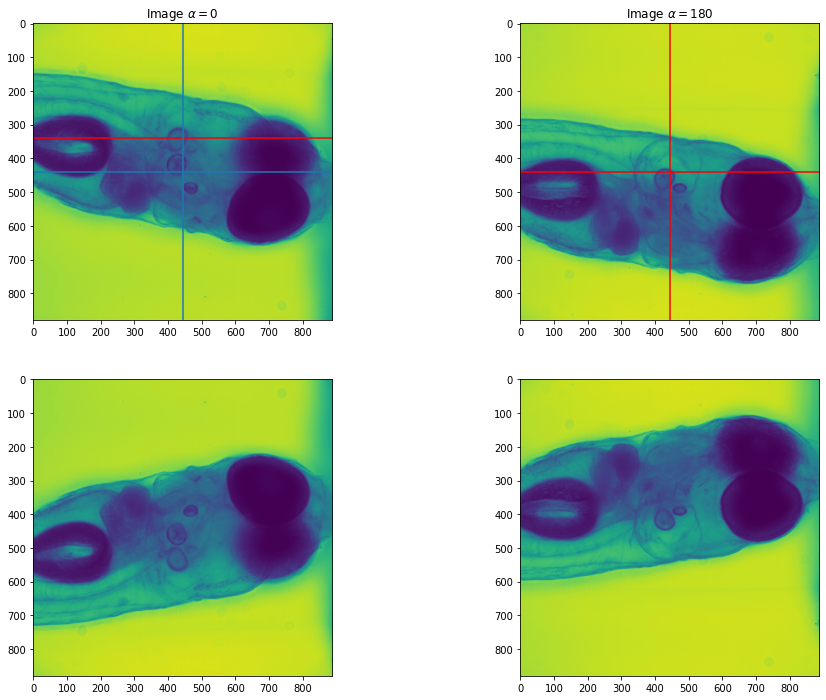

In [ ]:
x = 30
df_angles = df.dataset[df.dataset.Sample == 0].sort_values('Angle', axis = 0)
a_0 = df_angles[df_angles.Angle == x]['Image'].iloc[0]
a_1 = df_angles[df_angles.Angle == x+180]['Image'].iloc[0]

tx = 130
ty = 0

# a_1 = ndimage.shift(a_1, [tx, ty])

# q_prim_x = np.arange(0,a_0.shape[0])
# q_prim_y = np.arange(0,a_0.[1])

fig, ax = plt.subplots(2,2, figsize = (16,12))
ax[0,0].imshow(np.flipud(a_0))
ax[0,0].set_title(r'Image $\alpha = 0$')
ax[0,0].axhline(a_0.shape[0]//2)
ax[0,0].axhline(a_0.shape[0]//2-100, color = 'r')

ax[0,0].axvline(a_0.shape[1]//2)
# ax[0].plot((2q_prim_x)+3)

ax[0,1].imshow(a_1)
ax[0,1].axhline(a_0.shape[0]//2, color ='r')
ax[0,1].axvline(a_0.shape[1]//2, color ='r')
ax[0,1].set_title(r'Image $\alpha = 180$')

ax[1,0].imshow(a_0)
ax[1,1].imshow(np.flipud(a_1))